In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib import rc
import pickle
import pandas as pd
from scipy.stats import pearsonr
from matplotlib.ticker import MaxNLocator
import rasterio
import sys  

sys.path.insert(1, '../')
from GCCM_gao import run_GCCM, get_embedding, get_lag_indices
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Set specific font sizes
plt.rcParams.update({
    'font.size': 12,          # Global font size
    'axes.titlesize': 10,     # Title font size
    'axes.labelsize': 10,     # X and Y axis labels font size
    'xtick.labelsize': 8,    # X-axis tick labels font size
    'ytick.labelsize': 8,    # Y-axis tick labels font size
    'legend.fontsize': 10,    # Legend font size
})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [6]:
# load data
x = rasterio.open('../data/dTRI_aligned.tif') # cause
xMatrix_al = x.read(1)
xMatrix_al = xMatrix_al.T
y = rasterio.open('../data/Cu_aligned.tif') # effect
yMatrix_al = y.read(1)
yMatrix_al = yMatrix_al.T
z = rasterio.open('../data/nlights_aligned.tif') # cause
zMatrix_al = z.read(1)
zMatrix_al = zMatrix_al.T
zMatrix_al = zMatrix_al.astype(float)

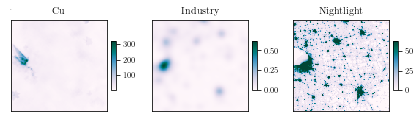

In [7]:
fig, ax = plt.subplots(1,3, figsize=(6, 4))
p0 = ax[0].imshow(yMatrix_al, origin='lower', interpolation='none', cmap='PuBuGn')
p1 = ax[1].imshow(xMatrix_al, origin='lower', interpolation='none', cmap='PuBuGn')
p2 = ax[2].imshow(zMatrix_al, origin='lower', interpolation='none', cmap='PuBuGn')

# Add colorbars next to each image
cbar0 = fig.colorbar(p0, ax=ax[0], fraction=0.046, pad=0.04, aspect=10)
cbar1 = fig.colorbar(p1, ax=ax[1], fraction=0.046, pad=0.04, aspect=10)
cbar2 = fig.colorbar(p2, ax=ax[2], fraction=0.046, pad=0.04, aspect=10)

# Add titles to each subplot
ax[0].set_title(r'Cu')
ax[0].text(0, 1.1, r'$\textbf a)$', transform=ax[0].transAxes, fontsize=1, horizontalalignment='center')
ax[1].set_title(r'Industry')
ax[2].set_title(r'Nightlight')

# Remove axis tick labels
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
#plt.savefig('plots_paper/pollution_data_aligned.pdf', bbox_inches='tight')

In [8]:
lib_sizes = np.arange(10,120,20)
dims = np.arange(1,10)

In [9]:
def get_mean(results, arr):
    xy = []
    yx = []
    for i in arr:
        xy.append(results['x_xmap_y'][i]['mean'])
        yx.append(results['y_xmap_x'][i]['mean'])
    return np.array(xy), np.array(yx)
    
def get_interval(results, arr):
    xy_u = []
    xy_l = []
    yx_u = []
    yx_l = []
    for i in arr:
        u, l = results['x_xmap_y'][i]['conf']
        xy_u.append(u)
        xy_l.append(l)
        u, l = results['y_xmap_x'][i]['conf']
        yx_u.append(u)
        yx_l.append(l)
    return np.array(xy_u), np.array(xy_l), np.array(yx_u), np.array(yx_l)

In [11]:
# Load the results from file
# python results
with open('../pollution_results/gao_Cu/Iresults.pkl', 'rb') as pickle_file:
    iresults = pickle.load(pickle_file)
with open('../pollution_results/gao_Cu/Nresults.pkl', 'rb') as pickle_file:
    nresults = pickle.load(pickle_file)
ix_xmap_y, iy_xmap_x = get_mean(iresults, lib_sizes)
nx_xmap_y, ny_xmap_x = get_mean(nresults, lib_sizes)

# R results
iresultsr = pd.read_csv('../../Gao_code/raster/results/Iresults.csv')
nresultsr = pd.read_csv('../../Gao_code/raster/results/Nresults.csv')

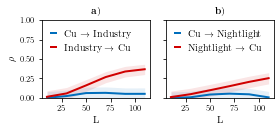

In [12]:
fig, ax = plt.subplots(1,2, figsize=(4,2), sharex=True, sharey=True)

p1, = ax[0].plot(lib_sizes, list(iresultsr['x_xmap_y_means']),  c='#006EBC', lw=2, label = r'Cu $\rightarrow$ Industry' ) #Industry xmap Cu
ax[0].fill_between(lib_sizes, np.array(iresultsr['x_xmap_y_lower']), np.array(iresultsr['x_xmap_y_upper']), color='#006EBC', alpha=0.1, lw=0)
p2, = ax[0].plot(lib_sizes, list(iresultsr['y_xmap_x_means']),  c='#D00000', lw=2, label = r'Industry $\rightarrow$ Cu')
ax[0].fill_between(lib_sizes, np.array(iresultsr['y_xmap_x_lower']), np.array(iresultsr['y_xmap_x_upper']), color='#D00000', alpha=0.1, lw=0)
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))

ax[0].set_ylim(0,1)
ax[0].set_title(r'$\textbf a)$')
ax[0].set_xlabel('L')
ax[0].set_ylabel(r'$\rho$')

legend = ax[0].legend([p1, p2], [r'Cu $\rightarrow$ Industry', r'Industry $\rightarrow$ Cu'], scatterpoints=1,
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)}, 
               handlelength=0.5, loc='upper left', frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)
    
ax[1].plot(lib_sizes, list(nresultsr['x_xmap_y_means']),c='#006EBC', lw=2, label = r'Cu $\rightarrow$ Nightlight')
ax[1].fill_between(lib_sizes, np.array(nresultsr['x_xmap_y_lower']), np.array(nresultsr['x_xmap_y_upper']), color='#006EBC', alpha=0.1, lw=0)
ax[1].plot(lib_sizes, list(nresultsr['y_xmap_x_means']), c='#D00000', lw=2, label = r'Nightlight $\rightarrow$ Cu')
ax[1].fill_between(lib_sizes, np.array(nresultsr['y_xmap_x_lower']), np.array(nresultsr['y_xmap_x_upper']), color='#D00000', alpha=0.1, lw=0)
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))

ax[1].set_ylim(0,1)
ax[1].set_title(r'$\textbf b)$')
ax[1].set_xlabel('L')
legend = ax[1].legend([p1, p2], [r'Cu $\rightarrow$ Nightlight', r'Nightlight $\rightarrow$ Cu'], scatterpoints=1,
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)}, 
               handlelength=0.5, loc='upper left', frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

plt.tight_layout()
#plt.savefig('plots_paper/GCCM_original_paper.pdf', bbox_inches='tight')

In [13]:
# Load the results from file
# python results
with open('../pollution_results/corrected_input_Cu/Iresults.pkl', 'rb') as pickle_file:
    iresults = pickle.load(pickle_file)
with open('../pollution_results/corrected_input_Cu/Nresults.pkl', 'rb') as pickle_file:
    nresults = pickle.load(pickle_file)
ix_xmap_y_al, iy_xmap_x_al = get_mean(iresults, lib_sizes)
nx_xmap_y_al, ny_xmap_x_al = get_mean(nresults, lib_sizes)

In [14]:
i_xy_u, i_xy_l, i_yx_u, i_yx_l = get_interval(iresults, lib_sizes)
n_xy_u, n_xy_l, n_yx_u, n_yx_l = get_interval(nresults, lib_sizes)

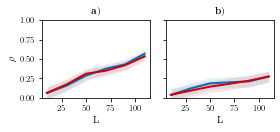

In [15]:
fig, ax = plt.subplots(1,2, figsize=(4,2), sharex=True, sharey=True)

p3,= ax[0].plot(lib_sizes, ix_xmap_y_al,  c='#006EBC',  lw=2, label = r'Cu $\rightarrow$ Industry')
ax[0].fill_between(lib_sizes, i_xy_l, i_xy_u, color='#006EBC', alpha=0.1, label='Confidence Interval', lw=0)
p4,= ax[0].plot(lib_sizes, iy_xmap_x_al,  c='#D00000',  lw=2, label = r'Industry $\rightarrow$ Cu')
ax[0].fill_between(lib_sizes, i_yx_l, i_yx_u, color='#D00000', alpha=0.1, label='Confidence Interval', lw=0)
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))

ax[0].set_ylim(0,1)
ax[0].set_title(r'$\textbf a)$')
ax[0].set_xlabel('L')
ax[0].set_ylabel(r'$\rho$')


p3,= ax[1].plot(lib_sizes, nx_xmap_y_al,  c='#006EBC',  lw=2, label = r'Cu $\rightarrow$ Nightlight')
ax[1].fill_between(lib_sizes, n_xy_l, n_xy_u, color='#006EBC', alpha=0.1, label='Confidence Interval', lw=0)
p4,= ax[1].plot(lib_sizes, ny_xmap_x_al,  c='#D00000',  lw=2, label = r'Nightlight $\rightarrow$ Cu')
ax[1].fill_between(lib_sizes, n_yx_l, n_yx_u, color='#D00000', alpha=0.1, label='Confidence Interval', lw=0)
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))

ax[1].set_ylim(0,1)
ax[1].set_title(r'$\textbf b)$')
ax[1].set_xlabel('L')


plt.tight_layout()
#plt.savefig('plots_paper/GCCM_fix_paper.pdf', bbox_inches='tight')